# Descriptive Statistics

In [1]:
from pyspark.sql.functions import size, expr, when, col, explode, array_max, udf
from pyspark.sql.types import IntegerType, ArrayType
from pyspark.ml.feature import Bucketizer
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import sys
import os

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [17]:
spark = SparkSession.builder.appName("Forum Question Analyzer") \
    .config("spark.jars.packages", "com.databricks:spark-xml_2.12:0.17.0") \
    .getOrCreate()
posts = spark.read \
    .format("com.databricks.spark.xml") \
    .option("rootTag", "posts") \
    .option("rowTag", "row") \
    .load("tex.stackexchange.com/Posts.xml") \
    .alias('posts')
users = spark.read \
    .format("com.databricks.spark.xml") \
    .option("rootTag", "users") \
    .option("rowTag", "row") \
    .load("tex.stackexchange.com/Users.xml") \
    .alias('users')
tags = spark.read \
    .format("com.databricks.spark.xml") \
    .option("rootTag", "tags") \
    .option("rowTag", "row") \
    .load("tex.stackexchange.com/Tags.xml") \
    .alias('tags')

In [24]:
#UDF - Fast way to change tag names to tag counts from Tags table

tag_counts = tags.select("_TagName", "_Count").rdd.collectAsMap()

def replace_tags_with_counts(tags):
    return [tag_counts.get(tag, 0) for tag in tags]

replace_tags_with_counts_udf = udf(replace_tags_with_counts, ArrayType(IntegerType()))

questions = posts.filter(posts._PostTypeId==1)
answers = posts.filter(posts._PostTypeId == 2)
questions = questions.withColumn("_Tags", expr("split(substring(_Tags, 2, length(_Tags) - 2), '><')")) \
            .withColumn("_Body", size(expr("split(_Body, ' ')"))) \
            .withColumn("_Title", size(expr("split(_Title, ' ')")))

questions = questions.join(users, questions._OwnerUserId == users._Id).select(
    questions._Id.alias("QuestionId"),
    questions._Tags.alias("Tags"),
    questions._Body.alias("BodyLength"),
    questions._Title.alias("TitleLength"),
    expr("date_format(posts._CreationDate, 'yyyy')").alias("QuestionDate"),
    array_max(replace_tags_with_counts_udf(questions._Tags)).alias("TagsCountMax"),
    size(questions._Tags).alias("NumberOfTags"),
    users._Id.alias("OwnerId"),
    users._DownVotes.alias("OwnerDownVotes"),
    users._UpVotes.alias("OwnerUpVotes"),
    users._Reputation.alias("OwnerReputation"),
    users._Views.alias("OwnerViews"),
    expr("(posts._CreationDate - users._CreationDate)/31536000").cast("integer").alias("OwnerExperience"),
    when(col("_AcceptedAnswerId").isNull(), 0).otherwise(1).alias("Accepted")
)

questions = questions.filter(questions.OwnerExperience >= 0)

In [4]:
print("Posts count: ", posts.count())
print("Questions: ", questions.count())
print("Answers: ", answers.count())
acc = questions.Accepted.sum()
print(f"Accepted answers: {acc} ({acc / questions.count()*100:.2f}% of questions and {acc / answers.count()*100:.2f}% of answers)")

Posts count:  584821
Questions:  255804
Answers:  326115
Accepted answers: 153808 (60.13% of questions and 47.16% of answers)


## Tags

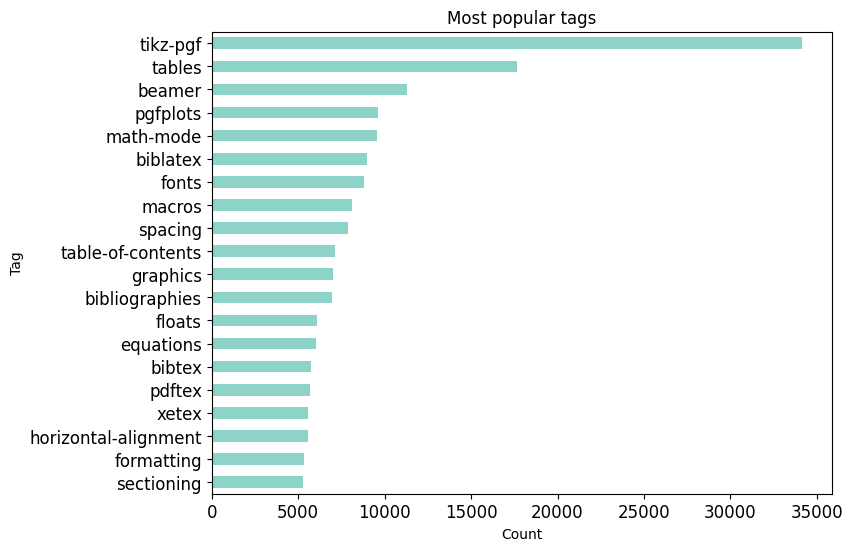

In [25]:
# Most popular tags
tags.select("_TagName", "_Count").orderBy("_Count", ascending=False).limit(20).toPandas()[::-1] \
    .plot.barh(x="_TagName", y="_Count", title="Most popular tags",
              figsize=(8, 6), rot=0, legend=False, fontsize=12,
              colormap='Set3', xlabel="Count", ylabel="Tag")
plt.show()

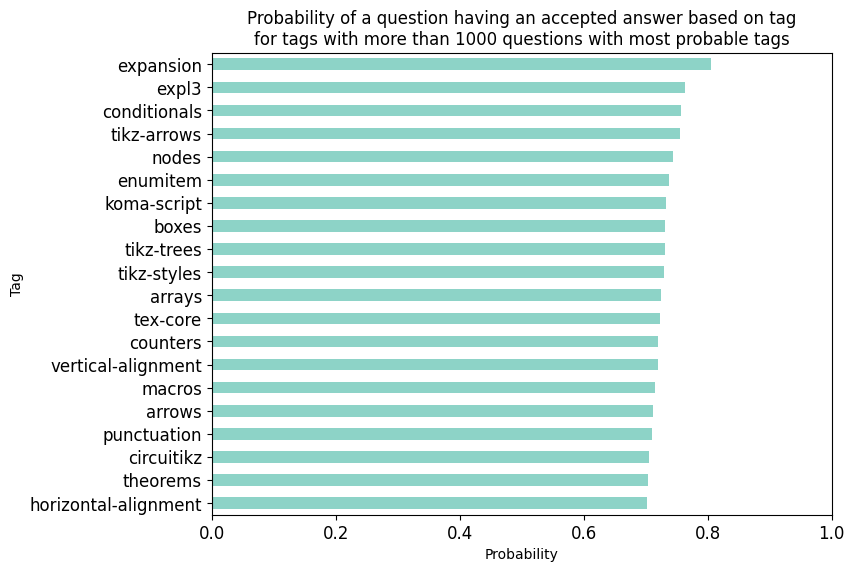

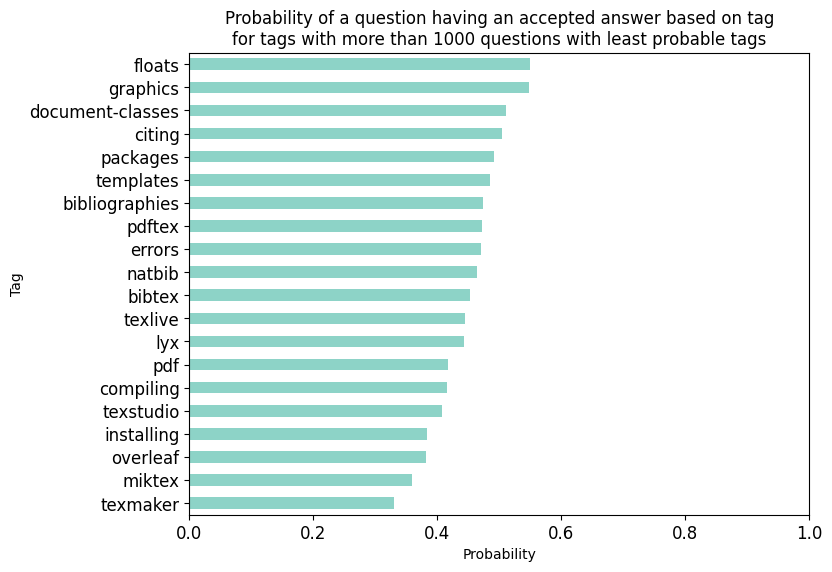

In [26]:
# Probability of a question having an accepted answer based on tag
questions_exploded = questions.select("*", explode(questions.Tags).alias("tag"))
prob = questions_exploded.groupBy("tag").agg({"Accepted": "avg"}).where("count(tag) > 1000")
prob.orderBy("avg(Accepted)", ascending=False).limit(20).toPandas()[::-1] \
    .plot.barh(x="tag", y="avg(Accepted)",
               title="Probability of a question having an accepted answer based on tag\n"
                     "for tags with more than 1000 questions with most probable tags", 
               figsize=(8, 6), rot=0, legend=False, fontsize=12, colormap='Set3',
               xlabel="Probability", ylabel="Tag", xlim=(0, 1))
prob.orderBy("avg(Accepted)").limit(20).toPandas() \
    .plot.barh(x="tag", y="avg(Accepted)",
               title="Probability of a question having an accepted answer based on tag\n"
                     "for tags with more than 1000 questions with least probable tags", 
               figsize=(8, 6), rot=0, legend=False, fontsize=12, colormap='Set3',
               xlabel="Probability", ylabel="Tag", xlim=(0, 1))
plt.show()

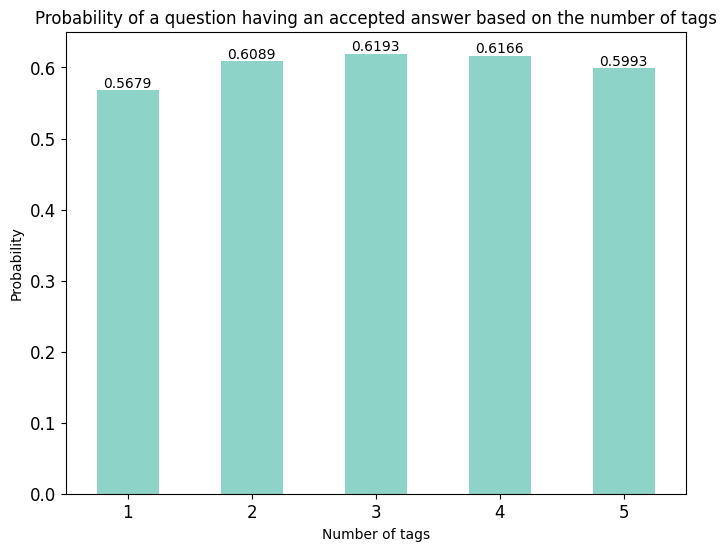

In [27]:
# Probability of a question having an accepted answer based on the tag number
ax = questions.groupBy("NumberOfTags").agg({"Accepted": "avg"}).orderBy("NumberOfTags").toPandas() \
         .plot.bar(x="NumberOfTags", y="avg(Accepted)",
                   title="Probability of a question having an accepted answer based on the number of tags", 
                   figsize=(8, 6), rot=0, legend=False, fontsize=12, colormap='Set3',
                   xlabel="Number of tags", ylabel="Probability")
ax.bar_label(ax.containers[0], fmt='%.4f')
plt.show()

## Question details

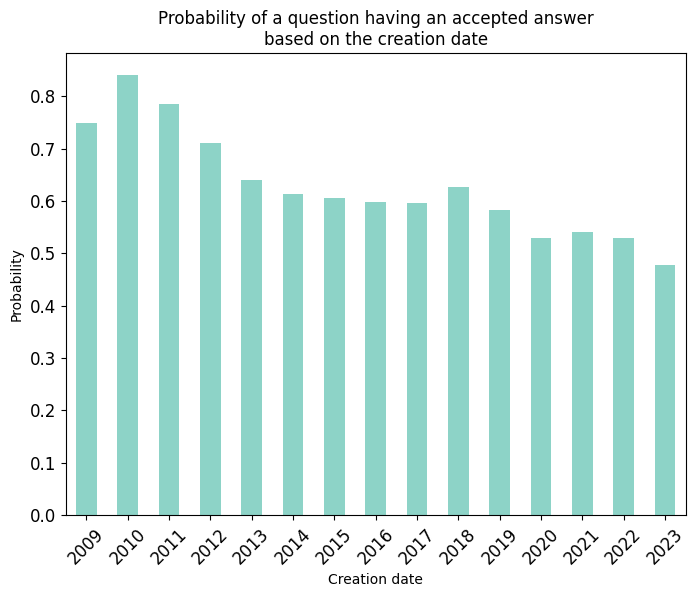

In [28]:
# Histogram of acceptance rate based on question creation date
questions.groupBy("QuestionDate").agg({"Accepted": "avg"}).orderBy("QuestionDate").toPandas() \
         .plot.bar(x="QuestionDate", y="avg(Accepted)",
                   title="Probability of a question having an accepted answer\n"
                         "based on the creation date", 
                   figsize=(8, 6), rot=45, legend=False, fontsize=12, colormap='Set3',
                   xlabel="Creation date", ylabel="Probability")
plt.show()

## User details

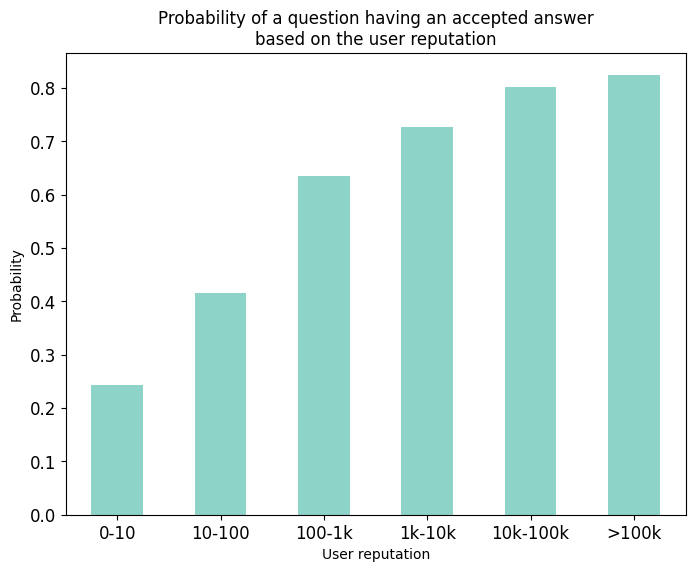

In [29]:
# Probability of a question having an accepted answer based on the user reputation
bucketizer = Bucketizer(splits=[0, 10, 100, 1000, 10000, 100000, float("inf")], inputCol="OwnerReputation", outputCol="reputation_bucket")
questions_bucketed = bucketizer.transform(questions)
ax = questions_bucketed.groupBy("reputation_bucket").agg({"Accepted": "avg"}).orderBy("reputation_bucket").toPandas() \
         .plot.bar(x="reputation_bucket", y="avg(Accepted)",
                   title="Probability of a question having an accepted answer\n"
                         "based on the user reputation", 
                   figsize=(8, 6), rot=0, legend=False, fontsize=12, colormap='Set3',
                   xlabel="User reputation", ylabel="Probability")
ax.set_xticklabels(["0-10", "10-100", "100-1k", "1k-10k", "10k-100k", ">100k"])
plt.show()

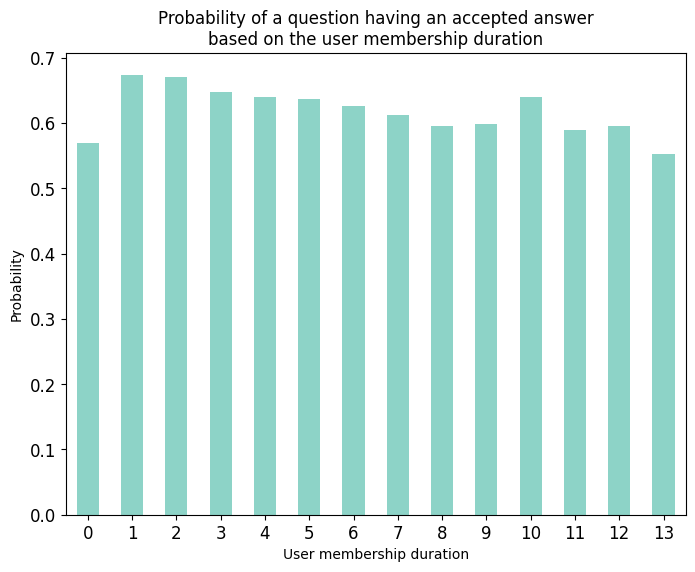

In [31]:
questions.groupBy("OwnerExperience").agg({"Accepted": "avg"}).orderBy("OwnerExperience").toPandas() \
         .plot.bar(x="OwnerExperience", y="avg(Accepted)",
                   title="Probability of a question having an accepted answer\n"
                         "based on the user membership duration", 
                   figsize=(8, 6), rot=0, legend=False, fontsize=12, colormap='Set3',
                   xlabel="User membership duration", ylabel="Probability")
plt.show()